Lab 4 Recurrent Neural Network
===

## Contents
A. 20 Newsgroups
    1. Text Data Preprocessing for 20 news groups
    2. Linear Classifiers (MultinomialNB with TF-IDF feature selection, Logistic Regression)
    3. Pure CNN based text classifier with pretrained word embedding
    4. LSTM based RNN text classifier with pretrained word embedding
    5. Stacked and Bidirectional LSTM RNN examples
    6. LSTM based RNN text classifier with pretrained word embedding trained via Truncated BPTT (TBPTT)
B. Consumer Finance Complaints
    1. Text Data Proprocessing for complaint data

## Data
You'll need to download and uncompress the following:

1. 20 newsgroups 
    1. [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) **(16.5Mb)**
    2. Note: you should put the 20_newsgroups directory in the same directory as this notebook

2. US Consumer Finance Complaints 
    1. [Kaggle Competition](https://www.kaggle.com/cfpb/us-consumer-finance-complaints/data) **(90.4Mb)**
    2. Note: you should put the consumer_complaints.csv file in the same directory as this notebook
    
3. GloVe word embeddings -- better than word2vec 
    1. [GloVE 6B](https://nlp.stanford.edu/projects/glove/) **(822Mb)**
    2. Note: you should download glove.6B.zip, unzip it, and put glove.6B in the same directory as this notebook
    
## Assignment
This assignment is the easiest of the four assignments.  This is intentional -- you should gain quick experience with the RNN (and how slow they are to train) in order to guide your final project choice and allow you to start into your final project ASAP.

This assignment is simply about using RNNs to train classifiers.  Encoder-decoder RNN models will be explored in a different lab (for the auto-correct example), but they are far slower to train than the RNNs used in this assignment (which are standard RNNs, not the encoder-decoder models).

Your basic choices in RNNs are the following:
    1. For text: word embedding (typically word2vec or GloVe, but you can also train them yourself!)
    2. Number of latent layers (stacked layers)
    3. Dimensions of latent layers
    4. Whether the latent layers are bidirectional or unidirectional
    5. Type of latent layer transition (linear, linear with sigmoid, LSTM, GRU, ...)
    6. Choice of optimizer, batch size, learning rates and other parameters for some optimizers
    7. Many more complex choices for latent layer that typically require modifying the Tensorflow model directly (not covered here)
    
Your assignment tasks (you can commit different notebooks for each question, just clearly label them Q1 and Q2):

**Q1.** Increase the epochs of the 20 newsgroups examples to at least 20 epochs and run this notebook overnight to get results... you can save the results in a different notebook and commit to your assignment repository (we simply want to verify that you ran this notebook for at least 20 epochs).  Directly below this question, answer (a) which architecture worked best and why you hypothesize that is the case, and (b) do the same for the worst performing architecture.
    
**Q2.** Run the above architectures for the financial data (note that this data is typically much shorter in length).  Try out at least two different architectures (not just optimizer settings, etc.) to see if you can improve the results.  Directly below this question, (a) describe the two architectures you proposed and why you think they might improve results, (b) answer which architecture worked best (reference a graph) and why you hypothesize this is the case, and (c) do the same for the worst performing architecture.

(a). In this experiement, I proposed 2 different architectures, the 1st one is GRU and the 2nd one is 2-layer RNN (get every state output from 1st layer of LSTM and pass as sequence input to second layer). Since GRU directly exposes the full hidden content without any control, the computation would be cheaper than LSTM. The 2 layer LSTM could train our model deeper with higher non-linear features, this may lead to better accuracy. According to the final result plot, except the LR and NB, the best performed model is GRU and the worst is simple LSTM, however, all the output does not vary too much with each other. GRU could perform best in this case could be caused by its simpler configuration with less parameter for avoid overfitting. Truncation could further help gradients vanishing and explosion problem, therefore, the simple LSTM without truncation would perform slightly lower than other models in accuracy.


**Submission.** You can commit different notebooks for each question, just label them and include Q1 or Q2 in the filename.

In [1]:
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Basic Packages

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils import to_categorical

# US Consumer Finance Complaints

### Constants

In [46]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6b')
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'consumer_complaints.csv')
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 100
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.4

### Packages

In [47]:
import pandas as pd
import re
import itertools
import string
from io import BytesIO
from collections import Counter
from time import time
import datetime
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

### Data Preprocessing

In [48]:
def clean_str(string):
    """
    Tokenization/string cleaning (partially modified)
    """
    string = re.sub(r"[^A-Za-z0-9()!?\'\`%$]", " ", string) # keep also %$ but removed comma
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\$", " $ ", string) #yes, isolate $
    string = re.sub(r"\%", " % ", string) #yes, isolate %
    string = re.sub(r"\s{2,}", " ", string)
    
    # fixing XXX and xxx like as word
    string = re.sub(r'\S*(x{2,}|X{2,})\S*',"xxx",string)
    # removing non ascii
    string = re.sub(r'[^\x00-\x7F]+', "", string) 
    
    return string.strip().lower()

In [49]:
def get_complaints(path):
    # Read the input dataset 
    d = pd.read_csv(path, 
                    usecols=('product','consumer_complaint_narrative'),
                    dtype={'consumer_complaint_narrative': object})
    # Only interested in data with consumer complaints
    d=d[d['consumer_complaint_narrative'].notnull()]
    d=d[d['product'].notnull()]
    d.reset_index(drop=True,inplace=True)
    d['consumer_complaint_narrative'] = d['consumer_complaint_narrative'].apply(clean_str)
    
    le = preprocessing.LabelEncoder()
    label_name = d['product'].tolist()
    le.fit(label_name)
    d['label'] = le.transform(label_name)
    return d['consumer_complaint_narrative'].tolist(), d['product'].tolist(), d['label'].tolist()

In [50]:
texts, labels_index, labels = get_complaints(TEXT_DATA_DIR)
class_names=set(labels_index)
labels_index=class_names

In [51]:
indices = np.arange(len(texts))
np.random.shuffle(indices)
num_validation_samples = int(VALIDATION_SPLIT * len(texts))

## Text Data Processing

In [52]:
def data_preprocessing(texts, labels, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    if classifier == "NeuralNetwork":
        tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
        
        plt.figure()
        plt.hist([len(x) for x in sequences])
        plt.xlabel('Length of Document')
        plt.ylabel('Number of Documents')
        plt.title('Statistic of Data')
        plt.grid(True)
        plt.show()
        
        word_index = tokenizer.word_index
        
        with open('tokenizer.pickle', 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
        
    else:
        vectorizer = TfidfVectorizer()
        data = vectorizer.fit_transform(texts)
    
    labels = to_categorical(np.asarray(labels))  
    data = data[indices]
    labels = labels[indices]

    x_train = data[:-num_validation_samples]
    y_train = labels[:-num_validation_samples]
    x_val = data[-num_validation_samples:]
    y_val = labels[-num_validation_samples:]
    
    return x_train, y_train, x_val, y_val, word_index        

In [53]:
experiment_result = dict()

## SKLEARN

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [56]:
x_train, y_train, x_val, y_val, _ = data_preprocessing(texts, 
                                                       labels, 
                                                       indices, 
                                                       num_validation_samples, 
                                                       classifier="SKLEARN")

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [57]:
clf =  MultinomialNB(alpha=0.1)
clf.fit(x_train, np.argmax(y_train, axis=1))
pred = clf.predict(x_val)
experiment_result['NB'] = metrics.accuracy_score(np.argmax(y_val, axis=1), pred)

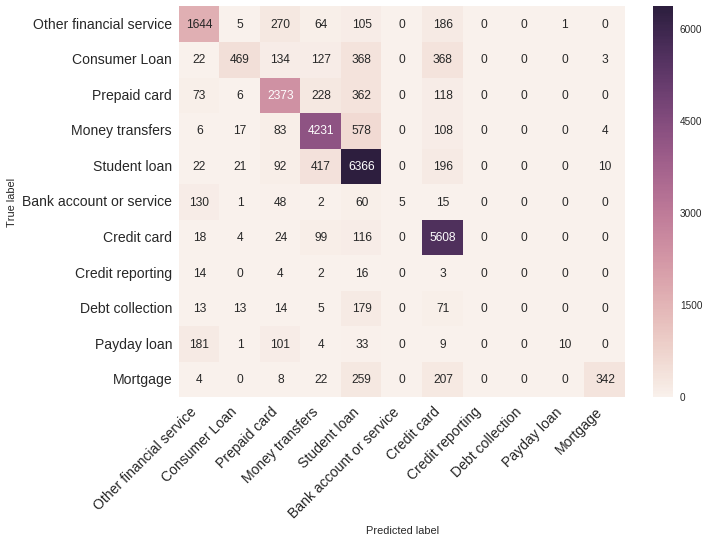

In [58]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), pred), 
                       class_names)

In [59]:
clf =  LogisticRegression()
clf.fit(x_train, np.argmax(y_train, axis=1))
pred = clf.predict(x_val)
experiment_result['LR'] = metrics.accuracy_score(np.argmax(y_val, axis=1), pred)

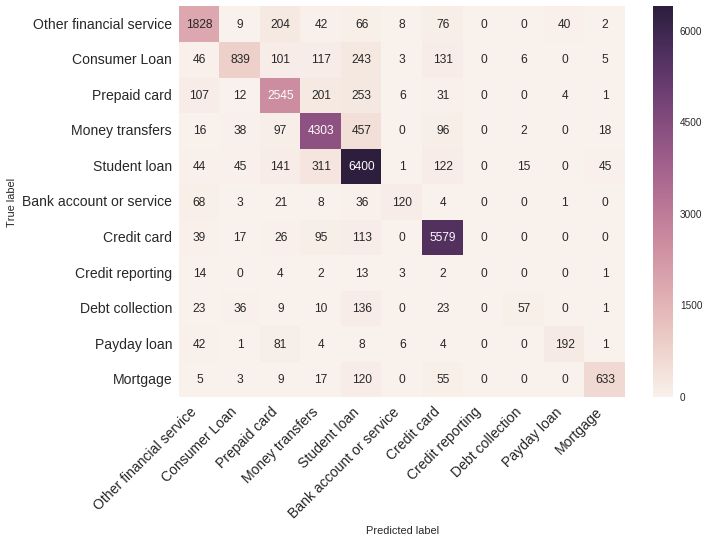

In [60]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), pred), 
                       class_names)

## Tensorflow

In [17]:
def show_curve(history):
    if type(history) is list:
        plt.plot(history)
    else:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [18]:
from tensorflow.python.keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, GRU, Concatenate, Dropout
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K

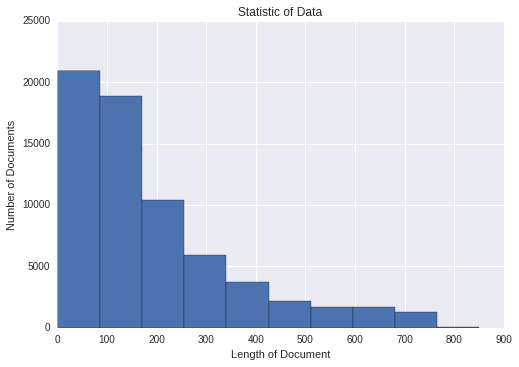

In [19]:
x_train, y_train, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels, 
                                                                indices, 
                                                                num_validation_samples, 
                                                                classifier="NeuralNetwork")

In [20]:
def get_embedding_matrix(word_index):
    
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)), encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, num_words

In [21]:
embedding_matrix, num_words = get_embedding_matrix(word_index)

### CNN

In [38]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

graph = tf.get_default_graph()
with graph.as_default():
    #Pretrained
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 2, activation='relu')(embedded_sequences)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 2, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 2, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 2, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['acc'])

    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=20, # Change this to at least 20 for final run
                        validation_data=(x_val, y_val))

Training model.
Train on 40084 samples, validate on 26722 samples
Epoch 1/20
40084/40084 [==============================] - 15s - loss: 1.1256 - acc: 0.6250 - val_loss: 0.7716 - val_acc: 0.7610
Epoch 2/20
40084/40084 [==============================] - 15s - loss: 0.6846 - acc: 0.7862 - val_loss: 0.6111 - val_acc: 0.8099
Epoch 3/20
40084/40084 [==============================] - 15s - loss: 0.5658 - acc: 0.8216 - val_loss: 0.5852 - val_acc: 0.8162
Epoch 4/20
40084/40084 [==============================] - 15s - loss: 0.5066 - acc: 0.8419 - val_loss: 0.6166 - val_acc: 0.8095
Epoch 5/20
40084/40084 [==============================] - 15s - loss: 0.4565 - acc: 0.8558 - val_loss: 0.5826 - val_acc: 0.8201
Epoch 6/20
40084/40084 [==============================] - 15s - loss: 0.4153 - acc: 0.8691 - val_loss: 0.5297 - val_acc: 0.8387
Epoch 7/20
40084/40084 [==============================] - 15s - loss: 0.3718 - acc: 0.8826 - val_loss: 0.6083 - val_acc: 0.8145
Epoch 8/20
40084/40084 [==============

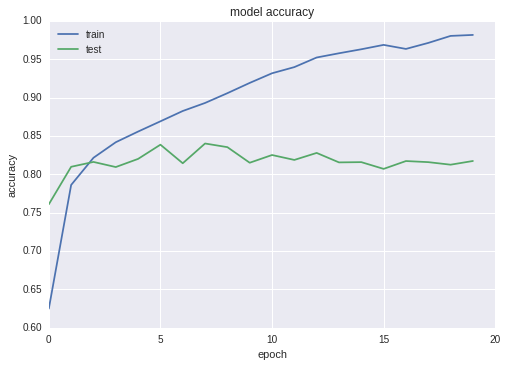

In [39]:
show_curve(history)

In [40]:
pred = model.predict(x_val)
experiment_result['CNN'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

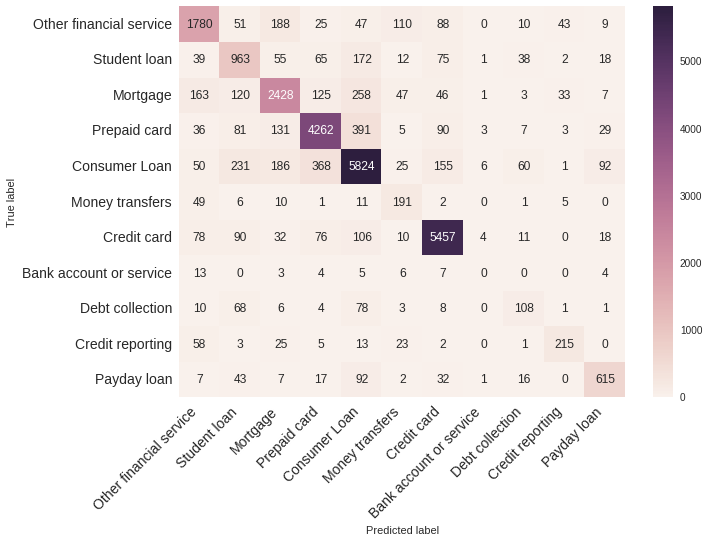

In [41]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       class_names)

### LSTM
1. need to run more 20 epochs to close to converge
2. Warning: It can take >3 hours!

In [54]:
#load from saved model
from keras.models import load_model
from keras.metrics import categorical_accuracy
import h5py

def load_predict(name):
    history = list()
    for epoch in range(20):
        print('Epoch {} :\n'.format(epoch))
        print('loading...')
        model = load_model(name+'Epoch'+str(epoch)+'.h5')
        print('predicting...')
        y_pred = model.predict(x_val)
        print('adding to history...\n')
        history.append(metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1)))
    return history,y_pred

In [55]:
from keras.callbacks import Callback

class WeightsSaver(Callback):
    def __init__(self, model,name):
        self.model = model
        self.name = name
        self.epoch = 0
        
    def on_epoch_end(self, epoch, logs={}):
        self.model.save(self.name+'Epoch'+str(self.epoch)+'.h5')
        self.epoch+=1

In [59]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a single layer LSTM recurrent neural network
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    # Replace LSTM with GRU if you want
    x,_,_ = LSTM(EMBEDDING_DIM, return_state=True)(embedded_sequences)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=20, # Change this to at least 20 for final run
                      validation_data=(x_val, y_val),\
                      callbacks=[WeightsSaver(model,'LSTM')])

Training model.
Train on 40084 samples, validate on 26722 samples
Epoch 1/20
40084/40084 [==============================] - 250s - loss: 1.5755 - acc: 0.4517 - val_loss: 1.1746 - val_acc: 0.6216
Epoch 2/20
40084/40084 [==============================] - 249s - loss: 0.9296 - acc: 0.7052 - val_loss: 0.8825 - val_acc: 0.7181
Epoch 3/20
40084/40084 [==============================] - 249s - loss: 0.7353 - acc: 0.7689 - val_loss: 0.8241 - val_acc: 0.7347
Epoch 4/20
40084/40084 [==============================] - 249s - loss: 0.6365 - acc: 0.8003 - val_loss: 0.7095 - val_acc: 0.7709
Epoch 5/20
40084/40084 [==============================] - 249s - loss: 0.5780 - acc: 0.8178 - val_loss: 0.6640 - val_acc: 0.7946
Epoch 6/20
40084/40084 [==============================] - 250s - loss: 0.5310 - acc: 0.8313 - val_loss: 0.7356 - val_acc: 0.7761
Epoch 7/20
40084/40084 [==============================] - 250s - loss: 0.4972 - acc: 0.8433 - val_loss: 0.6193 - val_acc: 0.8087
Epoch 8/20
40084/40084 [=======

In [61]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result['RNN'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

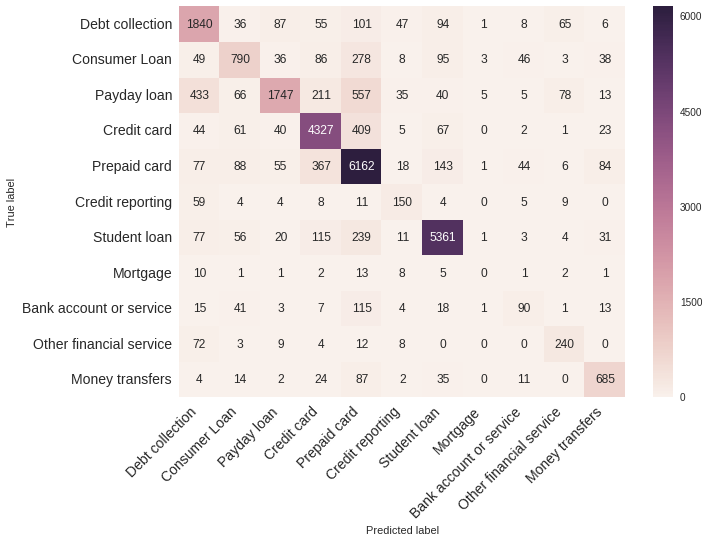

In [62]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       class_names)

In [36]:
def show_bar(experiment_result):
    df = pd.DataFrame(columns=['Algorithm','Score'])
    for key, value in experiment_result.items():
        df = df.append({'Algorithm': key, 'Score':value}, ignore_index=True)
    sns.barplot(x=df['Algorithm'], y=df['Score'], ci=None)
    plt.show()

In [ ]:
df = show_bar(experiment_result)

## Train Simple RNN with Truncated Backprop Through Time (TBPTT)

In [57]:
MAX_SEQUENCE_LENGTH = 100 # Chunk size for TBPTT

In [58]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [59]:
def data_preprocessing_v2(texts, labels, word_index, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    new_sequences = []
    new_labels = []
    
    texts = [texts[i] for i in indices]
    labels = [labels[i] for i in indices]
    texts = texts[:-num_validation_samples]
    labels = labels[:-num_validation_samples]
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    print(len(tokenizer.word_index))
    sequences = tokenizer.texts_to_sequences(texts)

    for index, sequence in enumerate(sequences):
        split_sequence = list(chunks(sequence, 100)) # Break sequences into 100-length chunks for training!
        label = labels[index]
        new_sequences += split_sequence
        new_labels += [label]*len(split_sequence)

    print(len(new_sequences), len(new_labels))

    sequences = new_sequences
    labels = new_labels

    plt.figure()
    plt.hist([len(x) for x in sequences])
    plt.xlabel('Length of Document')
    plt.ylabel('Number of Documents')
    plt.title('Statistic of Data')
    plt.grid(True)
    plt.show()

    word_index = tokenizer.word_index
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    labels = to_categorical(np.asarray(labels))  
    
    return data, labels    

52942
96360 96360


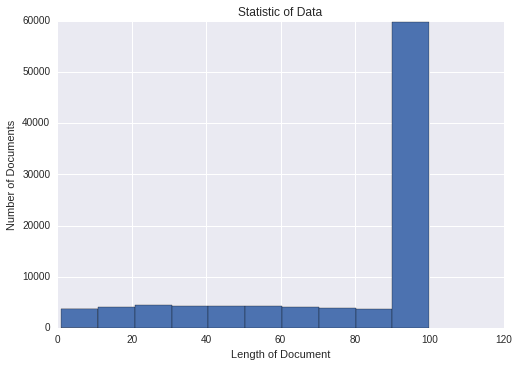

In [60]:
x_train, y_train = data_preprocessing_v2(texts, 
                                         labels,
                                         word_index,
                                         indices,
                                         num_validation_samples)

In [61]:
indices

array([34422, 15183, 11494, ...,  6518, 55490, 28059])

In [62]:
x_train.shape

(96360, 100)

In [63]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a single layer LSTM recurrent neural network
    sequence_input = Input(shape=(None,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    # Replace LSTM with GRU if you want
    x,_,_ = LSTM(EMBEDDING_DIM, return_state=True)(embedded_sequences)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=20, # Change this to at least 20 for final run
                      validation_data=(x_val, y_val),
                     callbacks=[WeightsSaver(model,'LSTM-Truncated')])

Training model.
Train on 96360 samples, validate on 26722 samples
Epoch 1/20
96360/96360 [==============================] - 145s - loss: 1.3735 - acc: 0.5284 - val_loss: 0.8391 - val_acc: 0.7328
Epoch 2/20
96360/96360 [==============================] - 143s - loss: 0.9528 - acc: 0.6890 - val_loss: 0.6376 - val_acc: 0.8000
Epoch 3/20
96360/96360 [==============================] - 144s - loss: 0.8572 - acc: 0.7211 - val_loss: 0.5735 - val_acc: 0.8210
Epoch 4/20
96360/96360 [==============================] - 143s - loss: 0.8033 - acc: 0.7390 - val_loss: 0.5427 - val_acc: 0.8307
Epoch 5/20
96360/96360 [==============================] - 143s - loss: 0.7649 - acc: 0.7514 - val_loss: 0.5658 - val_acc: 0.8227
Epoch 6/20
96360/96360 [==============================] - 142s - loss: 0.7298 - acc: 0.7618 - val_loss: 0.5328 - val_acc: 0.8349
Epoch 7/20
96360/96360 [==============================] - 140s - loss: 0.7004 - acc: 0.7704 - val_loss: 0.5559 - val_acc: 0.8277
Epoch 8/20
96360/96360 [=======

In [64]:
MAX_SEQUENCE_LENGTH = 2500

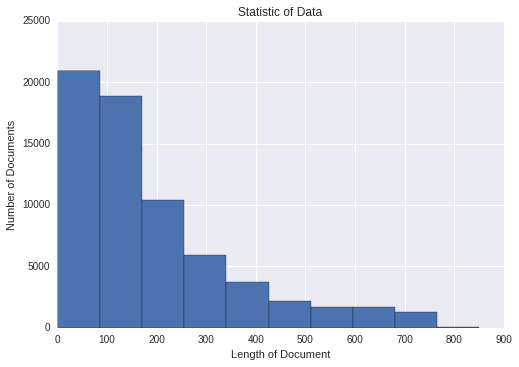

In [65]:
_, _, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels,  
                                                                indices,
                                                                num_validation_samples, 
                                                                classifier="NeuralNetwork")

In [ ]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result['RNN-Short'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

In [ ]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       class_names)

In [ ]:
df = show_bar(experiment_result)

## Train single layer GRU 

In [89]:
MAX_SEQUENCE_LENGTH = 100 # Chunk size for TBPTT

In [90]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [91]:
def data_preprocessing_v2(texts, labels, word_index, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    new_sequences = []
    new_labels = []
    
    texts = [texts[i] for i in indices]
    labels = [labels[i] for i in indices]
    texts = texts[:-num_validation_samples]
    labels = labels[:-num_validation_samples]
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    print(len(tokenizer.word_index))
    sequences = tokenizer.texts_to_sequences(texts)

    for index, sequence in enumerate(sequences):
        split_sequence = list(chunks(sequence, 100)) # Break sequences into 100-length chunks for training!
        label = labels[index]
        new_sequences += split_sequence
        new_labels += [label]*len(split_sequence)

    print(len(new_sequences), len(new_labels))

    sequences = new_sequences
    labels = new_labels

    plt.figure()
    plt.hist([len(x) for x in sequences])
    plt.xlabel('Length of Document')
    plt.ylabel('Number of Documents')
    plt.title('Statistic of Data')
    plt.grid(True)
    plt.show()

    word_index = tokenizer.word_index
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    labels = to_categorical(np.asarray(labels))  
    
    return data, labels    

52942
96360 96360


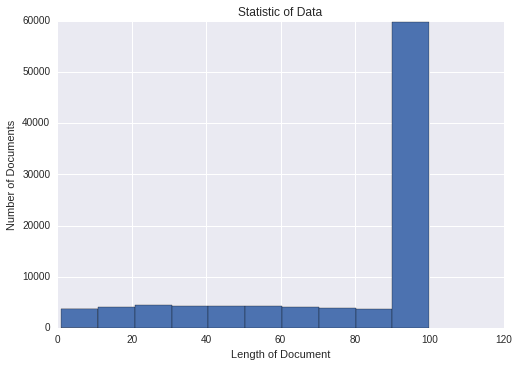

In [92]:
x_train, y_train = data_preprocessing_v2(texts, 
                                         labels,
                                         word_index,
                                         indices,
                                         num_validation_samples)

In [93]:
indices

array([34422, 15183, 11494, ...,  6518, 55490, 28059])

In [94]:
x_train.shape

(96360, 100)

In [102]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    print('Training model.')
    sequence_input = Input(shape=(None,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x,_ = GRU(EMBEDDING_DIM, return_state=True)(embedded_sequences)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)

    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=20, 
                      validation_data=(x_val, y_val))

Training model.
Train on 96360 samples, validate on 26722 samples
Epoch 1/20
96360/96360 [==============================] - 215s - loss: 1.2161 - acc: 0.5870 - val_loss: 0.7115 - val_acc: 0.7703
Epoch 2/20
96360/96360 [==============================] - 211s - loss: 0.8677 - acc: 0.7200 - val_loss: 0.5515 - val_acc: 0.8270
Epoch 3/20
96360/96360 [==============================] - 211s - loss: 0.7900 - acc: 0.7430 - val_loss: 0.5244 - val_acc: 0.8366
Epoch 4/20
96360/96360 [==============================] - 211s - loss: 0.7427 - acc: 0.7582 - val_loss: 0.5013 - val_acc: 0.8432
Epoch 5/20
96360/96360 [==============================] - 212s - loss: 0.7079 - acc: 0.7706 - val_loss: 0.5050 - val_acc: 0.8439
Epoch 6/20
96360/96360 [==============================] - 212s - loss: 0.6775 - acc: 0.7787 - val_loss: 0.4908 - val_acc: 0.8494
Epoch 7/20
96360/96360 [==============================] - 212s - loss: 0.6499 - acc: 0.7883 - val_loss: 0.4918 - val_acc: 0.8484
Epoch 8/20
96360/96360 [=======

In [103]:
MAX_SEQUENCE_LENGTH = 2500

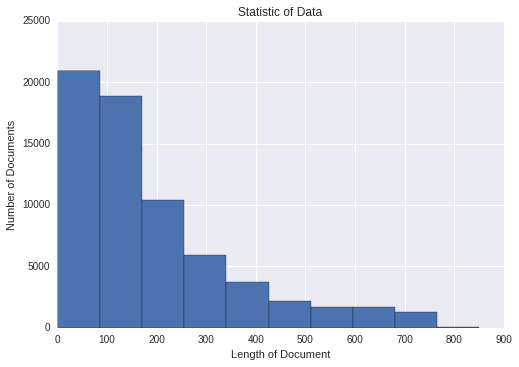

In [104]:
_, _, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels,  
                                                                indices,
                                                                num_validation_samples, 
                                                                classifier="NeuralNetwork")

In [105]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result['GRU'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

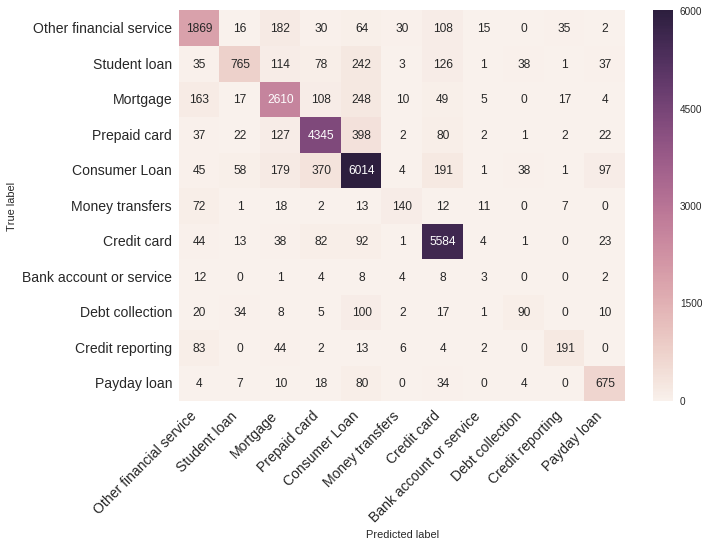

In [106]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       class_names)

In [ ]:
df = show_bar(experiment_result)

## Train 2-layer LSTM (in sequence, the 1st layer in time sequence, get output for every state)

In [22]:
MAX_SEQUENCE_LENGTH = 100 # Chunk size for TBPTT

In [23]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [24]:
def data_preprocessing_v2(texts, labels, word_index, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    new_sequences = []
    new_labels = []
    
    texts = [texts[i] for i in indices]
    labels = [labels[i] for i in indices]
    texts = texts[:-num_validation_samples]
    labels = labels[:-num_validation_samples]
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    print(len(tokenizer.word_index))
    sequences = tokenizer.texts_to_sequences(texts)

    for index, sequence in enumerate(sequences):
        split_sequence = list(chunks(sequence, 100)) # Break sequences into 100-length chunks for training!
        label = labels[index]
        new_sequences += split_sequence
        new_labels += [label]*len(split_sequence)

    print(len(new_sequences), len(new_labels))

    sequences = new_sequences
    labels = new_labels

    plt.figure()
    plt.hist([len(x) for x in sequences])
    plt.xlabel('Length of Document')
    plt.ylabel('Number of Documents')
    plt.title('Statistic of Data')
    plt.grid(True)
    plt.show()

    word_index = tokenizer.word_index
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    labels = to_categorical(np.asarray(labels))  
    
    return data, labels    

52942
96193 96193


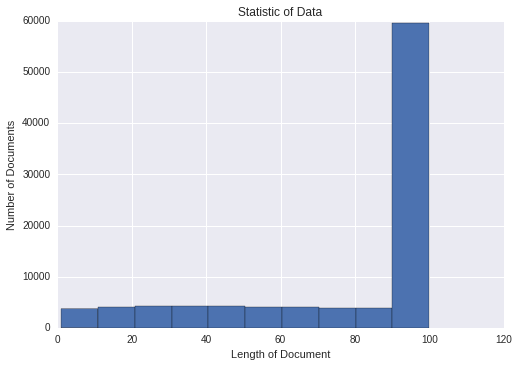

In [25]:
x_train, y_train = data_preprocessing_v2(texts, 
                                         labels,
                                         word_index,
                                         indices,
                                         num_validation_samples)

In [26]:
indices

array([13351, 27309, 21312, ..., 10806, 48175, 61426])

In [27]:
x_train.shape

(96193, 100)

In [30]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    print('Training model.')

    # train a single layer LSTM recurrent neural network
    sequence_input = Input(shape=(None,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = LSTM(EMBEDDING_DIM,return_sequences=True)(embedded_sequences)
    x = LSTM(EMBEDDING_DIM)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)

    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=20, 
                      validation_data=(x_val, y_val))

Training model.
Train on 96193 samples, validate on 26722 samples
Epoch 1/20
96193/96193 [==============================] - 278s - loss: 1.4116 - acc: 0.5104 - val_loss: 0.8054 - val_acc: 0.7451
Epoch 2/20
96193/96193 [==============================] - 272s - loss: 0.9456 - acc: 0.6940 - val_loss: 0.6349 - val_acc: 0.8050
Epoch 3/20
96193/96193 [==============================] - 274s - loss: 0.8525 - acc: 0.7243 - val_loss: 0.5672 - val_acc: 0.8243
Epoch 4/20
96193/96193 [==============================] - 273s - loss: 0.8024 - acc: 0.7396 - val_loss: 0.5710 - val_acc: 0.8221
Epoch 5/20
96193/96193 [==============================] - 272s - loss: 0.7643 - acc: 0.7517 - val_loss: 0.5143 - val_acc: 0.8387
Epoch 6/20
96193/96193 [==============================] - 263s - loss: 0.7327 - acc: 0.7616 - val_loss: 0.5157 - val_acc: 0.8404
Epoch 7/20
96193/96193 [==============================] - 258s - loss: 0.7041 - acc: 0.7710 - val_loss: 0.5153 - val_acc: 0.8403
Epoch 8/20
96193/96193 [=======

In [31]:
MAX_SEQUENCE_LENGTH = 2500

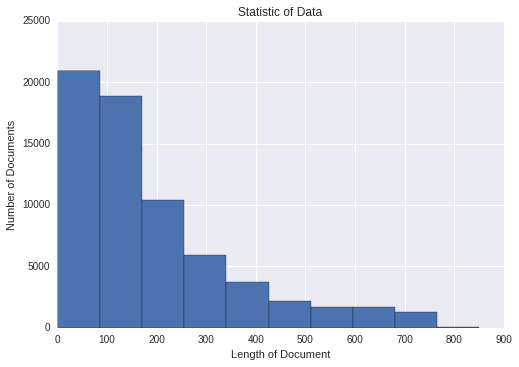

In [32]:
_, _, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels,  
                                                                indices,
                                                                num_validation_samples, 
                                                                classifier="NeuralNetwork")

In [33]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result['Time-Series_LSTM'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

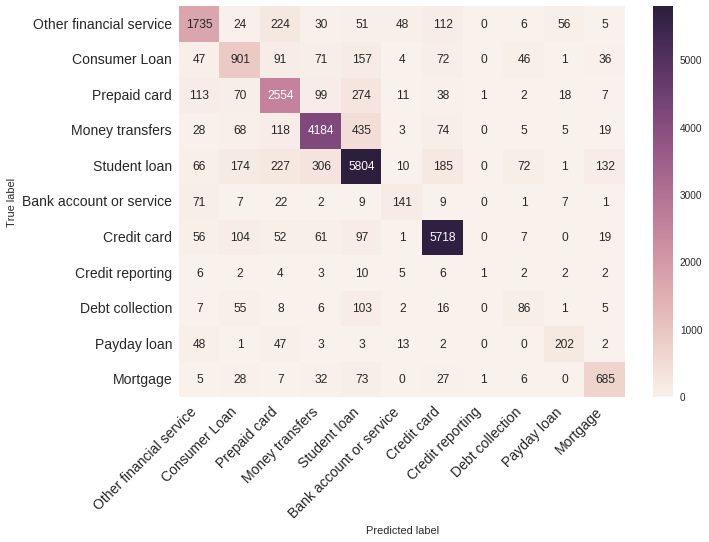

In [34]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       class_names)

/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


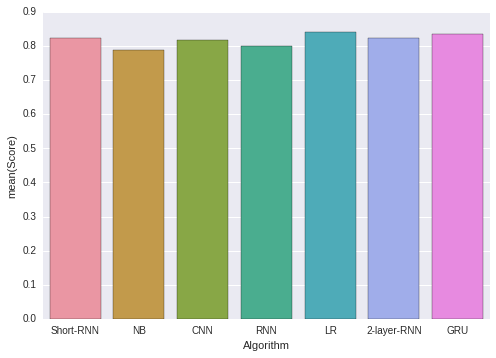

In [62]:
df = show_bar(experiment_result)